# Neo4j Example

In [1]:
#!sudo /venv/bin/pip install pyvis --quiet
#!sudo /venv/bin/pip install neo4j --quiet
#!sudo /venv/bin/pip install py2neo --quiet
#!sudo /venv/bin/pip install networkx --quiet

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Import Packages

In [3]:
import logging
from typing import Optional

import matplotlib.pyplot as plt
import neo4j as nj
import networkx as nx
import pandas as pd

import helpers.hdbg as hdbg
import helpers.hprint as hprint

In [4]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.12/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-db36d8d4-31fe-4b27-8c72-39b653dbcb46.json'


## Start Neo4j server

In [5]:
# Install Neo4j.
#!wget -O - https://debian.neo4j.com/neotechnology.gpg.key | sudo apt-key add -
#!echo 'deb https://debian.neo4j.com stable latest' | sudo tee /etc/apt/sources.list.d/neo4j.list
#!sudo apt update
#!sudo apt install neo4j -y
!sudo neo4j start

--2025-04-02 18:26:09--  https://debian.neo4j.com/neotechnology.gpg.key
Resolving debian.neo4j.com (debian.neo4j.com)... 3.164.230.126, 3.164.230.47, 3.164.230.52, ...
Connecting to debian.neo4j.com (debian.neo4j.com)|3.164.230.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3905 (3.8K) [application/pgp-keys]
Saving to: ‘STDOUT’

-                   100%[===================>]   3.81K  --.-KB/s    in 0s      

2025-04-02 18:26:09 (873 MB/s) - written to stdout [3905/3905]

OK
deb https://debian.neo4j.com stable latest
Get:1 https://download.docker.com/linux/ubuntu noble InRelease [48.8 kB]
Get:2 https://cli.github.com/packages stable InRelease [3917 B]                
Get:3 https://debian.neo4j.com stable InRelease [44.2 kB]                      
Hit:4 http://archive.ubuntu.com/ubuntu noble InRelease                         
Get:5 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]  
Get:6 http://archive.ubuntu.com/ubuntu noble-updates InRel

In [11]:
# URI and authentication details.
# URI = "neo4j://localhost:7687"
# USER = "neo4j"
# PASSWORD = "neo4j"
# 
# # Create a driver instance.
# driver = nj.GraphDatabase.driver(URI, auth=(USER, PASSWORD))
# driver.verify_connectivity()
# _LOG.info("Connection established.")
# 
# def change_password(tx, current_password, new_password):
#     tx.run(
#         "ALTER CURRENT USER SET PASSWORD FROM $current_password TO $new_password",
#         current_password=current_password,
#         new_password=new_password,
#     )
# 
# 
# # Change the password.
# with driver.session(database="system") as session:
#     session.write_transaction(change_password, "neo4j", "new_password")
# 
# # Reconnect with the new password.
# driver = nj.GraphDatabase.driver(URI, auth=("neo4j", "new_password"))
# driver.verify_connectivity()
# _LOG.info("Connection established.")

INFO  Connection established.


/tmp/ipykernel_790/3031343574.py:21: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(change_password, "neo4j", "new_password")


INFO  Connection established.


## Load the dataset

In [12]:
# Load the dataset into a Pandas DataFrame for initial processing.
csv_file = "data/netflix.csv"
data = pd.read_csv(csv_file)
data.head()

,show_id,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,type
0,81193313,Chocolate,NaN,"Ha Ji-won, Yoon Kye-sang, Jang Seung-jo, Kang ...",South Korea,"November 30, 2019",2019,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",Brought together by meaningful meals in the pa...,TV Show
1,81197050,Guatemala: Heart of the Mayan World,"Luis Ara, Ignacio Jaunsolo",Christian Morales,NaN,"November 30, 2019",2019,TV-G,67 min,"Documentaries, International Movies","From Sierra de las Minas to Esquipulas, explor...",Movie
2,81213894,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,"November 30, 2019",2019,TV-14,135 min,"Comedies, Dramas, International Movies",A goofy copywriter unwittingly convinces the I...,Movie
3,81082007,Atlantics,Mati Diop,"Mama Sane, Amadou Mbow, Ibrahima Traore, Nicol...","France, Senegal, Belgium","November 29, 2019",2019,TV-14,106 min,"Dramas, Independent Movies, International Movies","Arranged to marry a rich man, young Ada is cru...",Movie
4,80213643,Chip and Potato,NaN,"Abigail Oliver, Andrea Libman, Briana Buckmast...","Canada, United Kingdom",NaN,2019,TV-Y,2 Seasons,Kids' TV,"Lovable pug Chip starts kindergarten, makes ne...",TV Show


## Clean the dataset

In [13]:
# Replace missing values and ensure data consistency.
data["cast"] = data["cast"].fillna("")
data = data.dropna(subset=["director", "country"])
data["title"] = data["title"].str.strip()
# Display the cleaned dataset.
data.head()

,show_id,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,type
2,81213894,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,"November 30, 2019",2019,TV-14,135 min,"Comedies, Dramas, International Movies",A goofy copywriter unwittingly convinces the I...,Movie
3,81082007,Atlantics,Mati Diop,"Mama Sane, Amadou Mbow, Ibrahima Traore, Nicol...","France, Senegal, Belgium","November 29, 2019",2019,TV-14,106 min,"Dramas, Independent Movies, International Movies","Arranged to marry a rich man, young Ada is cru...",Movie
5,81172754,Crazy people,Moses Inwang,"Ramsey Nouah, Chigul, Sola Sobowale, Ireti Doy...",Nigeria,"November 29, 2019",2018,TV-14,107 min,"Comedies, International Movies, Thrillers",Nollywood star Ramsey Nouah learns that someon...,Movie
6,81120982,I Lost My Body,Jérémy Clapin,"Hakim Faris, Victoire Du Bois, Patrick d'Assum...",France,"November 29, 2019",2019,TV-MA,81 min,"Dramas, Independent Movies, International Movies","Romance, mystery and adventure intertwine as a...",Movie
7,81227195,Kalushi: The Story of Solomon Mahlangu,Mandla Dube,"Thabo Rametsi, Thabo Malema, Welile Nzuza, Jaf...",South Africa,"November 29, 2019",2016,TV-MA,107 min,"Dramas, International Movies",The life and times of iconic South African lib...,Movie


## Define a custom class

#############################################################################
Neo4jAPI
#############################################################################

In [14]:
class Neo4jAPI:
    """
    A wrapper class for interacting with the Neo4j database.
    """

    def __init__(self, uri, user, password) -> None:
        """
        Initialize the Neo4jAPI instance.

        :param uri: URI of the Neo4j database
        :param user: username for authentication
        :param password: password for authentication
        """
        self.driver = nj.GraphDatabase.driver(uri, auth=(user, password))

    def close(self) -> None:
        """
        Close the connection to the Neo4j database.
        """
        self.driver.close()

    def run_query(self, query: str, *, parameters: Optional[dict] = None):
        """
        Run a Cypher query on the Neo4j database.

        :param query: Cypher query to run
        :param parameters: parameters to pass to the query
        :return: Neo4j Result object
        """
        with self.driver.session() as session:
            return session.run(query, parameters)

    def load_data(self, dataframe: pd.DataFrame) -> None:
        """
        Load data from a Pandas DataFrame into Neo4j.

        :param dataframe: DataFrame to load
        """
        query = """
        MERGE (movie:Movie {title: $title, release_year: $release_year})
        MERGE (director:Director {name: $director})
        MERGE (director)-[:DIRECTED]->(movie)
        """
        with self.driver.session() as session:
            for _, row in dataframe.iterrows():
                # Skip rows with missing directors or titles.
                if pd.isna(row["title"]) or pd.isna(row["director"]):
                    continue
                params = {
                    "title": row["title"],
                    "release_year": row["release_year"],
                    "director": row["director"],
                }
                session.run(query, params)

    def visualize_graph(self) -> None:
        """
        Fetch the graph data from Neo4j and visualize it with better spacing,
        smaller nodes, directed edges, and a legend.
        """
        query = """
        MATCH (d:Director)-[r:DIRECTED]->(m:Movie)
        WHERE d.name <> 'Unknown'
        RETURN d.name AS director, m.title AS movie, m.release_year AS year
        """
        with self.driver.session() as session:
            # Fetch all results into a list to prevent the consumption issue.
            results = list(session.run(query))
        # Create the directed graph.
        G = nx.DiGraph()
        for record in results:
            director = record["director"]
            movie = record["movie"]
            year = record["year"]
            # Add nodes and edges
            G.add_node(director, label="Director", type="Director")
            G.add_node(movie, label=f"{movie} ({year})", type="Movie")
            G.add_edge(director, movie, relationship="DIRECTED")
        # Layout for better spacing (adjust `k` for spacing).
        pos = nx.spring_layout(G, seed=42, k=0.5)
        # Plot the graph.
        # Larger figure for better visibility.
        plt.figure(figsize=(15, 10))
        # Draw nodes with custom sizes and colors.
        director_nodes = [
            n for n, attr in G.nodes(data=True) if attr["type"] == "Director"
        ]
        movie_nodes = [
            n for n, attr in G.nodes(data=True) if attr["type"] == "Movie"
        ]
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=director_nodes,
            node_color="skyblue",
            node_size=800,
            label="Director",
        )
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=movie_nodes,
            node_color="lightgreen",
            node_size=500,
            label="Movie",
        )
        # Draw edges with arrows.
        nx.draw_networkx_edges(
            G, pos, arrowstyle="->", arrowsize=15, edge_color="gray"
        )
        # Draw labels.
        nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")
        # Draw edge labels.
        edge_labels = nx.get_edge_attributes(G, "relationship")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        # Add legend.
        plt.legend(scatterpoints=1, loc="upper right", fontsize=10)
        # Title and display.
        plt.title("Movie-Director Graph", fontsize=16)
        plt.axis("off")
        plt.show()

## Initialize Neo4j API

In [15]:
# Create an instance of the Neo4jAPI class.
neo4j_api = Neo4jAPI(
    uri="neo4j://localhost:7687", user="neo4j", password="new_password"
)

## Load Data Into Neo4j

In [16]:
# Load the dataset into the Neo4j database.
neo4j_api.load_data(data[:40])

## Visualize the Graph

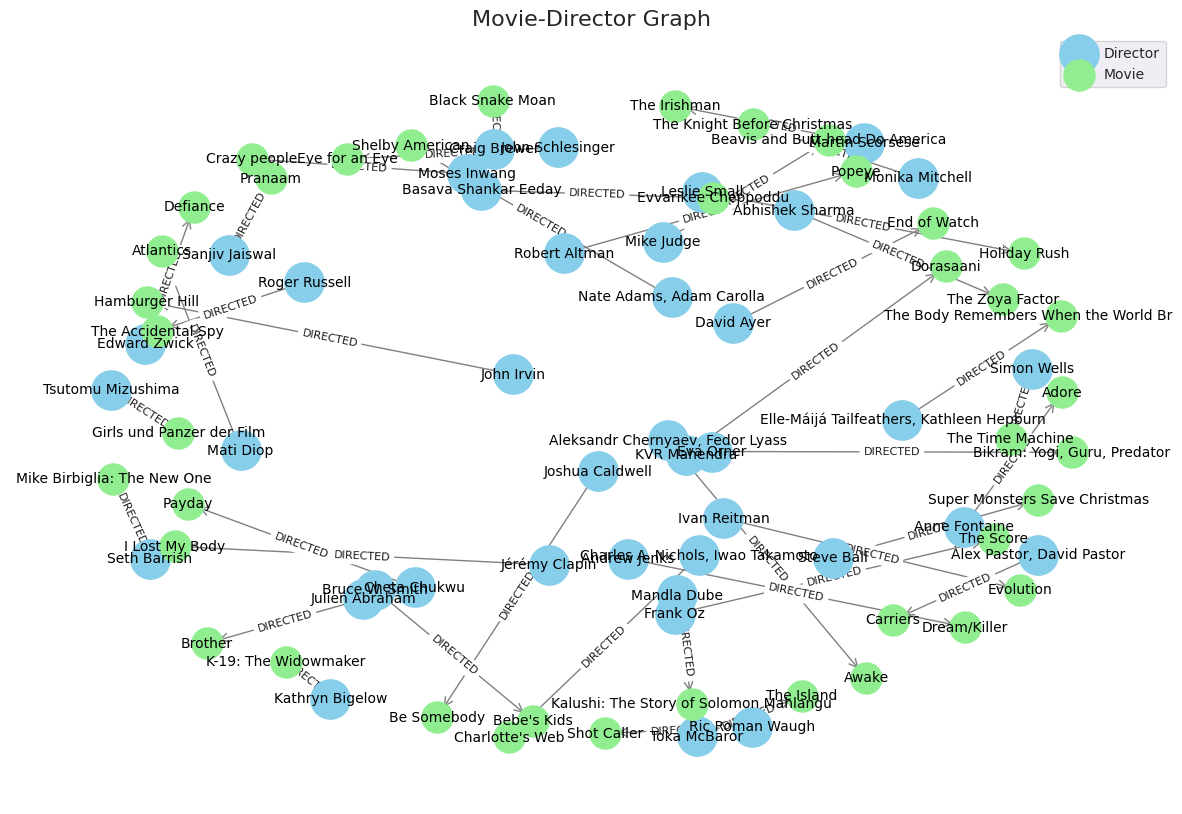

In [17]:
# Generate an interactive visualization of the Neo4j graph.
neo4j_api.visualize_graph()

## Close the Neo4j Connection

In [18]:
# Clean up by closing the connection to the database
neo4j_api.close()